In [ ]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

In [ ]:
import numpy as np
import pandas as pd
from typing import Union, List
import datetime
from pycmqlib3.utility import misc

from pycmqlib3.utility.dbaccess import *
from pycmqlib3.utility import dataseries
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *

# check nearby rolling

In [ ]:
start_date = datetime.date(2021,1,2)
end_date = datetime.date(2022,3,29)
nc_df1 = misc.nearby('lu', 1, start_date = start_date, end_date = end_date, roll_rule='-40b',shift_mode=1)
nc_df2 = misc.nearby('lu', 2, start_date = start_date, end_date = end_date, roll_rule='-40b',shift_mode=1)
nc_df1, nc_df2
#nc1_df = misc.nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=1)
#nc2_df = misc.nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=2)
#print(nc_df, nc1_df, nc2_df)

In [ ]:
start_date = datetime.date(2015,1,1)
end_date = datetime.date(2022,6,17)
#load_fut_by_product('i', 'DCE', start_date ,end_date, freq = 'd')
prodcode = 'ni'
df1 = dataseries.nearby(prodcode, n = 1, start_date = start_date, end_date = end_date,
           roll_rule = '-25b', freq = 'd', shift_mode = 1, 
           adj_field = 'close', calc_fields = ['open', 'close', 'high', 'low'], 
           fill_cont = False,
          )

df2 = misc.nearby(prodcode, n = 1, start_date = start_date, end_date = end_date, roll_rule = '-25b', freq = 'd', shift_mode = 1)

print(df1, df2)

# this is testing for new nearby rolling

In [ ]:
def prod_main_cont_filter(df, asset):
    contlist, exch = prod_main_cont_exch(asset)
    if asset == 'ni':
        flag = (df.expiry < datetime.date(2019, 6, 1)) & df.month.isin([1, 5, 9])
        flag = flag | ((df.expiry >= datetime.date(2019, 6, 1)) & df.month.isin(contlist))
    elif asset =='sn':
        flag = (df.expiry < datetime.date(2020, 6, 1)) & df.month.isin([1, 5, 9])
        flag = flag | ((df.expiry >= datetime.date(2020, 6, 1)) & df.month.isin(contlist))
    else:
        flag = df.month.isin(contlist)
    return flag

In [ ]:
prodcode = 'cu'
n = 1
start_date = datetime.date(2021,1,1)
end_date = datetime.date(2022,6,21)
roll_rule = '-20b'
freq = 'd'
shift_mode = 0 
adj_field = 'close'
calc_fields = ['open', 'close', 'high', 'low']
contract_filter = prod_main_cont_exch
fill_cont = False


In [ ]:
exch = misc.prod2exch(prodcode)
xdf = load_fut_by_product(prodcode, exch, start_date ,end_date, freq = freq)
xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
if freq == 'd':
    index_cols = ['date']        
elif freq == 'm':
    index_cols = ['date', 'min_id']
xdf = xdf.sort_values(['instID'] + index_cols)
if shift_mode == 2:
    xdf['price_chg'] = np.log(xdf[adj_field]).diff()
else:
    xdf['price_chg'] = xdf[adj_field].diff()      
xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
    xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
    xdf = xdf[xdf.date <= xdf['roll_date']]
else:
    xdf['roll_date'] = xdf['expiry']

In [ ]:
win = 3
thres = 20000
xdf['roll_ind'] = (xdf['volume'] + xdf['openInterest']).rolling(win).mean()
for w in range(1, win):
    if w ==1:
        flag = (xdf['instID'].shift(w) != xdf['instID'])
    else:
        flag = flag | (xdf['instID'].shift(w) != xdf['instID'])
# flag = flag | (xdf['roll_ind'] < thres)
xdf.loc[flag, 'roll_ind'] = np.nan
xdf['roll_ind'] = xdf['roll_ind'].fillna(method = 'bfill')

roll_df = pd.pivot_table(xdf, index = index_cols, columns = 'expiry', values = 'roll_ind', aggfunc = 'first')
cont_df = pd.pivot_table(xdf, index = index_cols, columns = 'expiry', values = 'instID', aggfunc = 'first')

print(roll_df, cont_df)
#oi_df = pd.pivot_table(xdf, index = index_cols, columns = 'expiry', values = 'openInterest', aggfunc = 'first')
#vol_df = pd.pivot_table(xdf, index = index_cols, columns = 'expiry', values = 'volume', aggfunc = 'first')


In [ ]:
if contract_filter:
    flag = contract_filter(xdf, prodcode)
    xdf = xdf[flag]
df = pd.pivot_table(xdf, index = index_cols, columns = 'expiry', values = 'instID', aggfunc = 'first')
df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
df1 = df1.reset_index()
col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
if len(col_df[col_df['instID'].isna()])> 0:
    if fill_cont:
        col_df = col_df.fillna(method = 'ffill')
    else:
        raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s, dates = %s' % 
        (prodcode, str(n), roll_rule, col_df[col_df['instID'].isna()]['date']))
out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')
if shift_mode > 0:
    cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
    if shift_mode == 2:
        adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
        out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
    else:
        adj_price = out_df[adj_field].iloc[-1] - cum_adj
        out_df['shift'] = adj_price - out_df[adj_field]    

    for cfield in calc_fields:
        if shift_mode == 2:
            out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
        else:
            out_df[cfield] = out_df[cfield] + out_df['shift']
else:
    out_df['shift'] = 0
out_df = out_df.set_index('date').rename(columns = {'instID': 'contract'})

# this is for backtest metric testing

In [17]:
nb_df['price_chg'] = (nb_df['close'] - nb_df['close'].shift(1)).fillna(0)
nb_df['holding'] = (nb_df['price_chg'] - nb_df['price_chg'].rolling(14).mean()).shift(1).fillna(0)


In [18]:
metrics = MetricsBase(nb_df['holding'].to_frame('al'), nb_df['price_chg'].to_frame('al'))


In [29]:
df1[df1['contract'] != df2['contract']]

,contract,open,high,low,close,volume,openInterest,expiry,month,price_chg,roll_date,shift
date,,,,,,,,,,,,
2018-12-10,ni1905,69550.0,70050.0,68430.0,69220.0,318478,253612,2019-05-15,5,-270.0,2019-04-04,-20090.0
2018-12-11,ni1905,69010.0,69460.0,68210.0,68740.0,418446,271776,2019-05-15,5,-480.0,2019-04-04,-20090.0
2018-12-12,ni1905,69090.0,69860.0,68600.0,68790.0,458924,286310,2019-05-15,5,50.0,2019-04-04,-20090.0
2018-12-13,ni1905,68820.0,69570.0,68020.0,69370.0,620038,299926,2019-05-15,5,580.0,2019-04-04,-20090.0
2018-12-14,ni1905,69210.0,69670.0,68820.0,68970.0,452296,299006,2019-05-15,5,-400.0,2019-04-04,-20090.0
2018-12-17,ni1905,68960.0,70950.0,68810.0,70830.0,560940,316302,2019-05-15,5,1860.0,2019-04-04,-20090.0
2018-12-18,ni1905,70530.0,71200.0,70230.0,70520.0,444790,303744,2019-05-15,5,-310.0,2019-04-04,-20090.0
2018-12-19,ni1905,70340.0,71300.0,68870.0,69290.0,661380,304082,2019-05-15,5,-1230.0,2019-04-04,-20090.0
2018-12-20,ni1905,69410.0,70200.0,69120.0,69990.0,498576,285060,2019-05-15,5,700.0,2019-04-04,-20090.0


<AxesSubplot:>

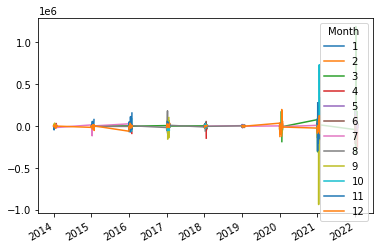

In [19]:
#metrics.holdings, metrics.returns
res = metrics.seasonal_pnl()
res['pnl'].plot()

<AxesSubplot:xlabel='date'>

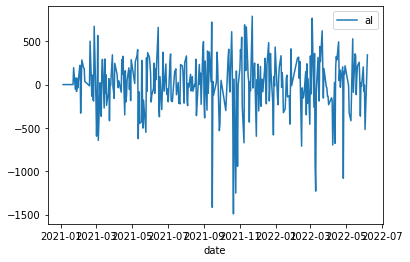

In [10]:
nb_df['holding'].to_frame('al').plot()

In [36]:
pd.to_datetime('2021-01-04').replace(day=1)

Timestamp('2021-01-01 00:00:00')

In [31]:
calendar_aggregation(nb_df, period = 'weekly', how = 'sum')

,open,high,low,close,volume,openInterest,month,price_chg,shift
date,,,,,,,,,
2021-01-08,1483.9,1543.1,1466.6,1524.9,281968,176433,15,18.9,-133.0
2021-01-15,1585.5,1616.8,1546.3,1575.8,550308,221988,15,-5.2,-133.0
2021-01-22,1554.8,1574.7,1529.9,1549.3,631411,232034,15,-7.1,-133.0
2021-01-29,1524.2,1550.3,1511.0,1528.8,107088,123896,20,2.3,-161.5
2021-02-05,1597.3,1628.2,1577.5,1614.2,187718,167511,20,24.0,-161.5
...,...,...,...,...,...,...,...,...,...
2022-05-06,1396.5,1413.7,1373.4,1395.9,73601,35847,14,24.8,0.0
2022-05-13,3406.1,3482.3,3323.5,3400.3,359275,112629,35,-2.3,0.0
2022-05-20,3514.8,3588.4,3446.9,3519.5,842207,160928,35,0.8,0.0


In [4]:
start_date = datetime.date(2014,1,1)
end_date = datetime.date(2022,6,17)

nb_df = dataseries.nearby('al', 1, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=1)
#nb1_df = dataseries.nearby('sc', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=1)
#nb2_df = nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=2)
print(nb_df)

           contract     open     high      low    close  volume  openInterest  \
date                                                                            
2014-01-06   al1403  13625.0  13645.0  13550.0  13550.0    7706         49150   
2014-01-07   al1403  13555.0  13575.0  13545.0  13550.0    4834         48892   
2014-01-08   al1403  13550.0  13575.0  13480.0  13505.0    4134         48702   
2014-01-09   al1403  13505.0  13530.0  13440.0  13440.0    5276         48812   
2014-01-10   al1403  13440.0  13450.0  13395.0  13405.0    7156         47574   
...             ...      ...      ...      ...      ...     ...           ...   
2022-06-13   al2208  20450.0  20530.0  19935.0  20010.0  118856        104803   
2022-06-14   al2208  19845.0  20125.0  19840.0  20015.0   88304        109073   
2022-06-15   al2208  19950.0  20180.0  19730.0  19815.0  102628        113882   
2022-06-16   al2208  19850.0  20235.0  19850.0  19990.0  102326        119692   
2022-06-17   al2208  19700.0

In [11]:
print(load_fut_by_product('eg', 'DCE', datetime.date(2022,5,20) ,datetime.date(2022,5,20)))
#print(load_fut_by_product('sc', 'INE', datetime.date(2022,3,2) ,datetime.date(2022,3,2)))

    instID        date    open    high     low   close  volume  openInterest
0   eg2206  2022-05-20  4916.0  4964.0  4829.0  4829.0     811         12841
1   eg2207  2022-05-20  4958.0  5012.0  4876.0  4893.0   50266         76150
2   eg2208  2022-05-20  4997.0  5050.0  4914.0  4932.0   24505         45958
3   eg2209  2022-05-20  5039.0  5080.0  4950.0  4956.0  431737        286305
4   eg2210  2022-05-20  5055.0  5100.0  4975.0  4975.0   10219         28978
5   eg2211  2022-05-20  5056.0  5119.0  4993.0  4993.0    6682         12155
6   eg2212  2022-05-20  5148.0  5148.0  5148.0  5148.0       0             8
7   eg2301  2022-05-20  5116.0  5156.0  5034.0  5042.0     451          1724
8   eg2302  2022-05-20  5226.0  5226.0  5226.0  5226.0       0             7
9   eg2303  2022-05-20  5104.0  5104.0  5104.0  5104.0       0             1
10  eg2304  2022-05-20  5050.0  5050.0  5050.0  5050.0       0             1


In [7]:
#nb_df[nb1_df['instID'] == nb_df['instID']]
#nb_df.close.plot(color='r')

#nb1_df.close.plot(color='y')
print(nb1_df.close.diff().max(), nb1_df.price_chg.max())
#nb_df[['close']].plot()
#flag = nb1_df.close.diff()>1.0
#nb1_df[flag | flag.shift(-1)]
#nb1_df.loc[datetime.date(2018,9,8):datetime.date(2018,9,20):]

NameError: name 'nb1_df' is not defined

In [2]:
start_date = datetime.date(2011,1,1)
end_date = datetime.date(2022, 1, 28)
prodcode = 'ZC'
roll_rule = '-30b'
shift_mode = 1
n = 1

adj_field = 'close'
calc_fields = ['open', 'close', 'high', 'low']
contract_filter = [1, 5, 9]

exch = misc.prod2exch(prodcode)
xdf = load_fut_by_product(prodcode, exch, start_date ,end_date)
xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
xdf = xdf.sort_values(['instID', 'date'])

if shift_mode == 2:
    xdf['price_chg'] = np.log(xdf[adj_field]).diff()
else:
    xdf['price_chg'] = xdf[adj_field].diff()        
xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
    xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
    xdf = xdf[xdf.date <= xdf['roll_date']]
else:
    xdf['roll_date'] = xdf['expiry']
if contract_filter:
    xdf = xdf[xdf.month.isin(contract_filter)]
df = pd.pivot_table(xdf, index = 'date', columns = 'expiry', values = 'instID', aggfunc = 'first')
df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
df1 = df1.reset_index()

col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
#if len(col_df[col_df['instID'].isna()])> 0:
#    raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s' % (prodcode, str(n), roll_rule))
col_df = col_df.fillna(method = 'ffill')
out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')

if shift_mode > 0:
    cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
    if shift_mode == 2:
        adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
        out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
    else:
        adj_price = out_df[adj_field].iloc[-1] - cum_adj
        out_df['shift'] = adj_price - out_df[adj_field]    

    for cfield in calc_fields:
        if shift_mode == 2:
            out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
        else:
            out_df[cfield] = out_df[cfield] + out_df['shift']
else:
    out_df['shift'] = 0
out_df = out_df.set_index('date')

In [6]:
load_fut_by_product('TA', 'CZCE', start_date ,end_date)

,instID,date,open,high,low,close,volume,openInterest
0,TA1101,2011-01-04,9986.0,10194.0,9948.0,10172.0,1826,26168
1,TA1102,2011-01-04,10152.0,10152.0,10152.0,10152.0,6,230
2,TA1103,2011-01-04,10340.0,10412.0,10320.0,10398.0,28,274
3,TA1104,2011-01-04,10498.0,10522.0,10344.0,10522.0,6,212
4,TA1105,2011-01-04,10430.0,10620.0,10372.0,10592.0,446228,225166
...,...,...,...,...,...,...,...,...
23472,TA209,2022-01-28,5516.0,5570.0,5446.0,5480.0,51837,142881
23473,TA210,2022-01-28,5572.0,5606.0,5506.0,5506.0,46,4695
23474,TA211,2022-01-28,5586.0,5616.0,5514.0,5538.0,36,2882
23475,TA212,2022-01-28,5602.0,5620.0,5590.0,5592.0,7,2519


In [144]:
#out_df[out_df.instID.isna()]

#out_df.loc[datetime.date(2017,11,20):datetime.date(2017,12,10),:]
#out_df.close.plot()
print(out_df.close.diff().max(),out_df.price_chg.max())

1.2449999999999903 1.2449999999999903


In [5]:
price_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
price_close = out_df['close'].iloc[-1] - price_adj
price_shift = price_close - out_df['close']
print(price_close, price_shift)

0      12365.0
1      12360.0
2      12380.0
3      12380.0
4      12435.0
        ...   
500    21025.0
501    21055.0
502    21525.0
503    21540.0
504    21950.0
Name: price_chg, Length: 505, dtype: float64 0     -1725.0
1     -1725.0
2     -1725.0
3     -1645.0
4     -1645.0
        ...  
500       0.0
501       0.0
502       0.0
503       0.0
504       0.0
Length: 505, dtype: float64


In [55]:
xdf = xdf.sort_values(['instID', 'date'])
xdf['chg'] = xdf['close'].diff()
flag = xdf['instID']!=xdf['instID'].shift(1)
xdf.loc[flag, 'chg'] = 0
print(xdf)

      instID        date     open     high      low    close  volume  \
0     al2001  2020-01-02  14355.0  14425.0  14355.0  14410.0    5391   
12    al2001  2020-01-03  14390.0  14425.0  14375.0  14410.0    8795   
24    al2001  2020-01-06  14425.0  14460.0  14390.0  14415.0    6025   
36    al2001  2020-01-07  14410.0  14420.0  14300.0  14300.0   10600   
48    al2001  2020-01-08  14260.0  14405.0  14260.0  14400.0    5570   
...      ...         ...      ...      ...      ...      ...     ...   
5967  al2301  2022-01-24  21140.0  21180.0  20840.0  20845.0      16   
5979  al2301  2022-01-25  20935.0  20940.0  20845.0  20850.0      31   
5991  al2301  2022-01-26  21220.0  21415.0  21145.0  21395.0      62   
6003  al2301  2022-01-27  21310.0  21395.0  21295.0  21395.0       3   
6015  al2301  2022-01-28  21365.0  21600.0  21340.0  21600.0      29   

      openInterest      expiry   roll_date    chg  
0            45835  2020-01-15  2019-12-04    0.0  
12           41670  2020-01-15 

In [4]:
adf = df.iloc[:, df.columns.get_level_values(0)=='close']
nb_df = nearby(adf, roll = 30)
print(nb_df[0])

close                                                         \
expiry     2021-01-15 2021-02-15 2021-03-15 2021-04-15 2021-05-17 2021-06-15   
date                                                                           
2021-01-04    15615.0    15430.0    15330.0    15290.0    15250.0    15205.0   
2021-01-05    15575.0    15370.0    15310.0    15290.0    15270.0    15220.0   
2021-01-06    15585.0    15400.0    15380.0    15390.0    15380.0    15335.0   
2021-01-07    15530.0    15320.0    15315.0    15325.0    15305.0    15280.0   
2021-01-08    15530.0    15340.0    15290.0    15300.0    15290.0    15215.0   
...               ...        ...        ...        ...        ...        ...   
2022-01-24        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-25        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-26        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-27        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-28        NaN        NaN        NaN        NaN        NaN        NaN   

                                                        ...             \
expiry     2021-07-15 2021-08-16 2021-09-15 2021-10-15  ... 2022-04-15   
date                                                    ...              
2021-01-04    15190.0    15165.0    15160.0    15095.0  ...        NaN   
2021-01-05    15190.0    15110.0    15105.0    15080.0  ...        NaN   
2021-01-06    15305.0    15275.0    15250.0    15230.0  ...        NaN   
2021-01-07    15245.0    15200.0    15260.0    15180.0  ...        NaN   
2021-01-08    15170.0    15160.0    15145.0    15075.0  ...        NaN   
...               ...        ...        ...        ...  ...        ...   
2022-01-24        NaN        NaN        NaN        NaN  ...    21025.0   
2022-01-25        NaN        NaN        NaN        NaN  ...    21055.0   
2022-01-26        NaN        NaN        NaN        NaN  ...    21525.0   
2022-01-27        NaN        NaN        NaN        NaN  ...    21540.0   
2022-01-28        NaN        NaN        NaN        NaN  ...    21895.0   

                                                                              \
expiry     2022-05-16 2022-06-15 2022-07-15 2022-08-15 2022-09-15 2022-10-17   
date                                                                           
2021-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2022-01-24    21000.0    20980.0    20930.0    20940.0    20990.0    20885.0   
2022-01-25    21045.0    21025.0    21010.0    21010.0    21015.0    21135.0   
2022-01-26    21495.0    21475.0    21445.0    21485.0    21425.0    21460.0   
2022-01-27    21525.0    21505.0    21465.0    21445.0    21435.0    21410.0   
2022-01-28    21820.0    21780.0    21735.0    21685.0    21670.0    21660.0   

                                             
expiry     2022-11-15 2022-12-15 2023-01-16  
date                                         
2021-01-04        NaN        NaN        NaN  
2021-01-05        NaN        NaN        NaN  
2021-01-06        NaN        NaN        NaN  
2021-01-07        NaN        NaN        NaN  
2021-01-08        NaN        NaN        NaN  
...               ...        ...        ...  
2022-01-24    20830.0    20770.0    20845.0  
2022-01-25    20990.0    20910.0    20850.0  
2022-01-26    21440.0    21430.0    21395.0  
2022-01-27    21400.0    21460.0    21395.0  
2022-01-28    21710.0    21620.0    21600.0  

[262 rows x 25 columns]

In [6]:
def nearby(prodcode, n = 1, start_date = None, end_date = None, 
           roll_rule = '-20b', shift_mode = 0, 
           adj_field = 'close', calc_fields = ['open', 'close', 'high', 'low'], 
           contract_filter = None, fill_cont = False,
          ):
    exch = misc.prod2exch(prodcode)
    xdf = load_fut_by_product(prodcode, exch, start_date ,end_date)
    xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
    xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
    xdf = xdf.sort_values(['instID', 'date'])

    if shift_mode == 2:
        xdf['price_chg'] = np.log(xdf[adj_field]).diff()
    else:
        xdf['price_chg'] = xdf[adj_field].diff()        
    xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
    if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
        xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
        xdf = xdf[xdf.date <= xdf['roll_date']]
    else:
        xdf['roll_date'] = xdf['expiry']
    if contract_filter:
        xdf = xdf[xdf.month.isin(contract_filter)]
    df = pd.pivot_table(xdf, index = 'date', columns = 'expiry', values = 'instID', aggfunc = 'first')
    df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
    df1 = df1.reset_index()
    col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
    if len(col_df[col_df['instID'].isna()])> 0:
        if fill_cont:
            col_df = col_df.fillna(method = 'ffill')
        else:
            raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s' % (prodcode, str(n), roll_rule))
    out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')
    if shift_mode > 0:
        cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
        if shift_mode == 2:
            adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
            out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
        else:
            adj_price = out_df[adj_field].iloc[-1] - cum_adj
            out_df['shift'] = adj_price - out_df[adj_field]    

        for cfield in calc_fields:
            if shift_mode == 2:
                out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
            else:
                out_df[cfield] = out_df[cfield] + out_df['shift']
    else:
        out_df['shift'] = 0
    out_df = out_df.set_index('date')
    return out_df

,instID,date,open,high,low,close,volume,openInterest
0,ME1203,2011-10-28,3199.0,3220.0,3130.0,3139.0,40508,3342
1,ME1204,2011-10-28,3150.0,3209.0,3143.0,3148.0,102,44
2,ME1205,2011-10-28,3192.0,3233.0,3172.0,3182.0,3024,424
3,ME1206,2011-10-28,3258.0,3258.0,3195.0,3195.0,4,2
4,ME1209,2011-10-28,3195.0,3263.0,3189.0,3198.0,108,62
...,...,...,...,...,...,...,...,...
14173,MA209,2022-01-28,2805.0,2895.0,2780.0,2794.0,15715,56821
14174,MA210,2022-01-28,2860.0,2902.0,2801.0,2801.0,1521,7209
14175,MA211,2022-01-28,2863.0,2901.0,2793.0,2814.0,17,14448
14176,MA212,2022-01-28,2889.0,2930.0,2832.0,2832.0,15,4949
